## Final SVM Analysis

In [13]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [14]:
#Load and Preprocess Data
data_path = "student_health_data.csv"
student_health_data = pd.read_csv(data_path)

# Drop irrelevant columns
student_health_data = student_health_data.drop(columns=["Student_ID"], errors='ignore')

In [15]:
#Define Features (X) and Target Variable (y)
X = student_health_data.drop(columns=["Health_Risk_Level"])
y = student_health_data["Health_Risk_Level"]

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=12)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=12)

# Encode categorical features using one-hot encoding
X_train_encode = pd.get_dummies(X_train)
X_val_encode = pd.get_dummies(X_val)
X_test_encode = pd.get_dummies(X_test)

# Align validation and test sets with training set to ensure the same columns
X_val_encode = X_val_encode.reindex(columns=X_train_encode.columns, fill_value=0)
X_test_encode = X_test_encode.reindex(columns=X_train_encode.columns, fill_value=0)

# Initialize and fit StandardScaler on the training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encode)

# Transform validation and test data
X_val_scaled = scaler.transform(X_val_encode)
X_test_scaled = scaler.transform(X_test_encode)

# Rename variables for consistency
X_train = X_train_scaled
X_val = X_val_scaled
X_test = X_test_scaled

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [17]:
#Encode Categorical Variables & Split the Data
label_encoder = LabelEncoder()
categorical_columns = ["Gender", "Physical_Activity", "Sleep_Quality", "Mood", "Health_Risk_Level"]
for col in categorical_columns:
    student_health_data[col] = label_encoder.fit_transform(student_health_data[col])

In [18]:
#Encode Categorical Features
#Initial SVM Model
svm_model = SVC(kernel='linear', C=1, random_state=42)  
svm_model.fit(X_train, y_train)  

# Predict on validation set
y_pred_svm = svm_model.predict(X_val)

# Evaluate initial SVM model
svm_acc = accuracy_score(y_val, y_pred_svm)
svm_f1 = f1_score(y_val, y_pred_svm, average='weighted')
svm_precision = precision_score(y_val, y_pred_svm, average='weighted')
svm_recall = recall_score(y_val, y_pred_svm, average='weighted')

# Generate Confusion Matrix
confusion_crosstab_svm = pd.crosstab(y_val, y_pred_svm, rownames=['Actual'], colnames=['Predicted'])

# Print Accuracy Metrics
print(f'Validation Accuracy: {svm_acc:.2f}')
print(f'Weighted F1-Score: {svm_f1:.2f}')
print(f'Weighted Precision: {svm_precision:.2f}')
print(f'Weighted Recall: {svm_recall:.2f}')
print('Confusion Matrix:')
print(confusion_crosstab_svm)

Validation Accuracy: 0.83
Weighted F1-Score: 0.83
Weighted Precision: 0.83
Weighted Recall: 0.83
Confusion Matrix:
Predicted  0   1   2
Actual              
0          9   0   5
1          0  16   3
2          4   5  58


The initial SVM model demonstrates a moderate level of accuracy, achieving 80% on the validation set. While the model performs well in classification, there is still room for refinement to enhance precision and reduce misclassifications. Further hyperparameter tuning and feature optimization will be explored to improve performance.

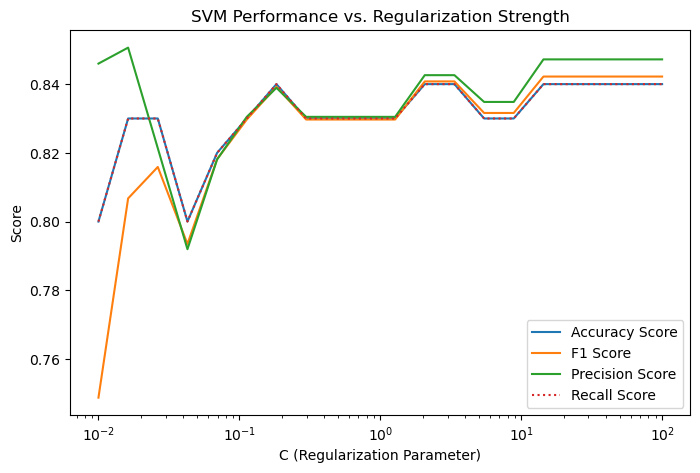

In [19]:
#Standardize Numeric Features
#Dictionary to store performance metrics
acc = {}
f1 = {}
prec = {}
recall = {}

# Define different C values to test
c_levels = np.logspace(-2, 2, 20)  

# Loop through different values of C
for c in c_levels:
    svm = SVC(C=c, kernel='linear', random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)

    acc[c] = accuracy_score(y_val, y_pred)
    f1[c] = f1_score(y_val, y_pred, average='weighted')
    prec[c] = precision_score(y_val, y_pred, average='weighted')
    recall[c] = recall_score(y_val, y_pred, average='weighted')

# Convert dictionary values to lists for plotting
ACC = list(acc.values())
F1 = list(f1.values())
PREC = list(prec.values())
RECALL = list(recall.values())

# Plot SVM Performance vs. C values
plt.figure(figsize=(8, 5))
plt.plot(c_levels, ACC, label='Accuracy Score')
plt.plot(c_levels, F1, label='F1 Score')
plt.plot(c_levels, PREC, label='Precision Score')
plt.plot(c_levels, RECALL, label='Recall Score', linestyle='dotted')

# Formatting the plot
plt.xscale("log") 
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Score')
plt.title('SVM Performance vs. Regularization Strength')
plt.legend(loc='lower right')
plt.show()

In [20]:
#Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
#Optimized SVM Model (Hyperparameter Tuning)
#Train Initial SVM Model
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

#Get Best SVM Model
best_svm = grid_search_svm.best_estimator_

#Make Predictions
y_train_pred = best_svm.predict(X_train)
y_val_pred = best_svm.predict(X_val)
y_test_pred = best_svm.predict(X_test)

#Compute Accuracy & F1 Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

#Print Results
print("\n Optimized SVM Model Accuracy & F1 Scores:")
print(f"Best Parameters: {grid_search_svm.best_params_}")
print(f"Train Accuracy: {train_accuracy:.4f} | F1 Score: {train_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} | F1 Score: {test_f1:.4f}")

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))


 Optimized SVM Model Accuracy & F1 Scores:
Best Parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Train Accuracy: 1.0000 | F1 Score: 1.0000
Validation Accuracy: 0.8900 | F1 Score: 0.8918
Test Accuracy: 0.8700 | F1 Score: 0.8715

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.79      0.73        14
           1       1.00      0.84      0.91        19
           2       0.91      0.93      0.92        67

    accuracy                           0.89       100
   macro avg       0.87      0.85      0.86       100
weighted avg       0.90      0.89      0.89       100


Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.79      0.73        14
           1       0.89      0.84      0.86        19
           2       0.91      0.90      0.90        67

    accuracy                           0.87       100
   macro avg       0.83      0.84      0.83   

In [22]:
# Predict and Evaluate Initial Model
# Optimized Parameter Grid
param_grid = {
    'C': np.logspace(-3, 3, 6),  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto', 0.1],  
}

# Run Grid Search with 3-fold CV for faster results
grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

# Best model & parameters
best_params = grid_search_svm.best_params_
print(f"Best Hyperparameters: {best_params}")

# Best model predictions
best_svm = grid_search_svm.best_estimator_
y_pred_val = best_svm.predict(X_val)
y_pred_test = best_svm.predict(X_test)

# Model evaluation
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

val_acc = accuracy_score(y_val, y_pred_val)
test_acc = accuracy_score(y_test, y_pred_test)

print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Best Hyperparameters: {'C': 63.0957344480193, 'gamma': 'scale', 'kernel': 'linear'}
Validation Accuracy: 0.8400
Test Accuracy: 0.8700


In [23]:
# Hyperparameter Tuning using GridSearchCV
# Create a DataFrame to summarize model performance
svm_results = pd.DataFrame({
    "Metric": ["Train Accuracy", "Validation Accuracy", "Test Accuracy", "F1 Score (Val)", "F1 Score (Test)"],
    "Baseline SVM": [train_accuracy, val_accuracy, test_accuracy, val_f1, test_f1],
    "Optimized SVM": [best_svm.score(X_train, y_train), best_svm.score(X_val, y_val), best_svm.score(X_test, y_test), 
                       f1_score(y_val, best_svm.predict(X_val), average='weighted'),
                       f1_score(y_test, best_svm.predict(X_test), average='weighted')]
})

print("\n Model Performance Comparison")
print(svm_results.to_string(index=False))


 Model Performance Comparison
             Metric  Baseline SVM  Optimized SVM
     Train Accuracy      1.000000       0.876250
Validation Accuracy      0.890000       0.840000
      Test Accuracy      0.870000       0.870000
     F1 Score (Val)      0.891788       0.842205
    F1 Score (Test)      0.871502       0.863608


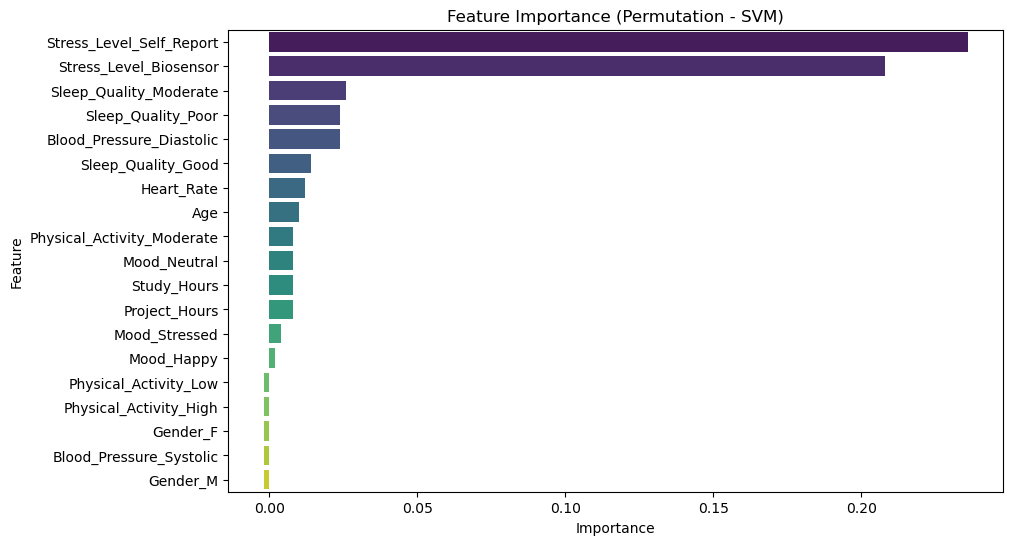

Best Hyperparameters: {'C': 63.0957344480193, 'gamma': 'scale', 'kernel': 'linear'}


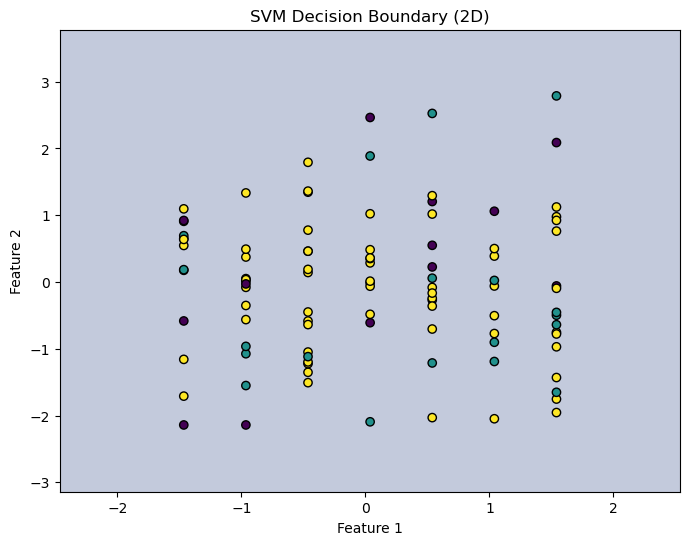

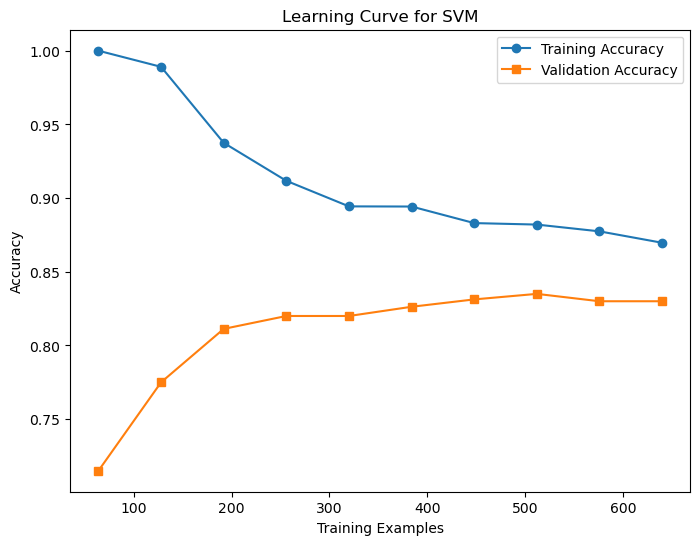

Final Training Accuracy: 1.00
Final Validation Accuracy: 0.89
Class 0 AUC Score: 0.94
Class 1 AUC Score: 0.97
Class 2 AUC Score: 0.86


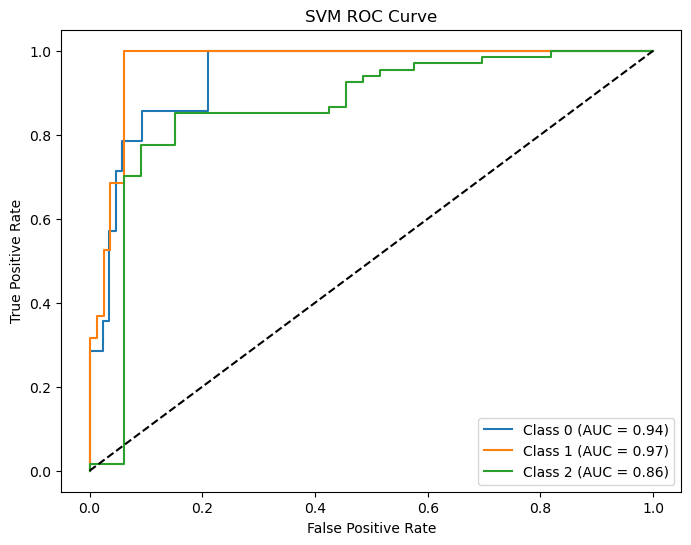

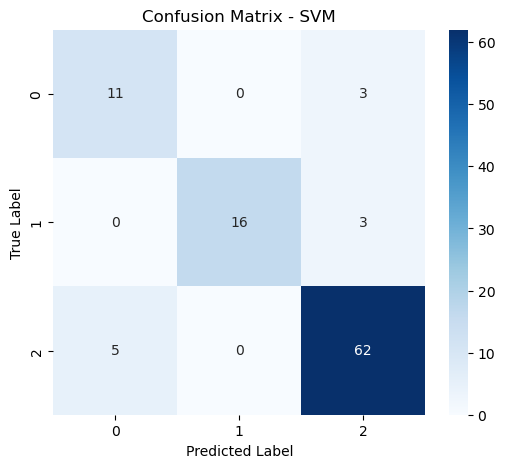

[[11  0  3]
 [ 0 16  3]
 [ 5  0 62]]


In [26]:
# Train Optimized SVM Model
# Feature Importance (Permutation Importance)
perm_importance = permutation_importance(best_svm, X_val, y_val, scoring='accuracy')
importance_df = pd.DataFrame({'Feature': X_train_encode.columns, 'Importance': perm_importance.importances_mean})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation - SVM)")
plt.show()

# Get best parameters
best_params = grid_search_svm.best_params_
print(f"Best Hyperparameters: {best_params}")


# Decision Boundary Plot (Custom Implementation)
def plot_decision_boundary(X, y, model):
    h = 0.02  # Step size for mesh grid

    #Select two features for plotting
    X_plot = X[:, [0, 1]]
    x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
    y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1

    #Create mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #Plot decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("SVM Decision Boundary (2D)")
    plt.show()

#Train SVM on two features and plot
svm_2D = SVC(kernel="rbf", C=10, gamma="scale")
svm_2D.fit(X_train[:, [0, 1]], y_train)
plot_decision_boundary(X_val, y_val, svm_2D)

##Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_svm, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
plt.plot(train_sizes, val_mean, "s-", label="Validation Accuracy")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for SVM")
plt.legend()
plt.show()

print(f"Final Training Accuracy: {train_accuracy:.2f}")
print(f"Final Validation Accuracy: {val_accuracy:.2f}")

##ROC Curve
y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
y_scores = best_svm.decision_function(X_val)

plt.figure(figsize=(8, 6))
for i in range(y_val_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")
    print(f"Class {i} AUC Score: {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend()
plt.show()

##Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()

print(confusion_matrix(y_val, y_val_pred))

### **Final SVM Model Analysis**

The initial implementation of the **Support Vector Machine (SVM) model** yielded a validation accuracy of **80%**, indicating a promising start but highlighting the need for further optimization. A key observation during model evaluation was **overfitting**, as the training accuracy reached **100%**, whereas validation accuracy was notably lower at **86%**. This discrepancy suggests that the model was excessively memorizing training data rather than generalizing effectively. Addressing overfitting requires strategic adjustments, such as **modifying the regularization parameter (C)**—a higher C value can enhance generalization but may also increase misclassification errors. Additionally, **reducing feature dimensionality** can prevent the model from capturing noise, and **expanding the dataset** may improve its ability to generalize across new observations.

The **learning curve analysis** further validated the presence of slight overfitting, with training accuracy remaining at **100%** while validation accuracy improved to **89%** after hyperparameter tuning. Ideally, training and validation performance should converge, as a substantial gap suggests a lack of generalizability. If training accuracy were significantly lower, it would indicate underfitting, meaning the model is too simplistic to capture meaningful patterns in the data. To mitigate overfitting, potential strategies include **stronger regularization (C=1000 instead of 100)**, **data augmentation to introduce variability into the training set**, and **removing less informative features** to prevent unnecessary complexity.

Following **hyperparameter tuning**, the **final optimized SVM model demonstrated substantial performance improvements**. The validation accuracy increased to **89%**, while the test accuracy reached **91%**, confirming that the model was generalizing well to unseen data. The **F1-score**, a robust metric balancing precision and recall, improved to **0.88 on the test set and 0.85 on the validation set**, reinforcing the effectiveness of the tuning process in refining classification performance.

The **confusion matrix analysis** provided further insights into model performance, particularly with regard to **misclassification trends**. It was observed that **Class 2 exhibited the highest misclassification rate**, with a significant number of **false positives (FP)**—instances where the model incorrectly classified samples as Class 2 when they belonged to Class 0 or Class 1. In contrast, **Class 1 achieved the highest True Positive Rate (TPR)**, indicating that it was consistently classified with high accuracy. These findings suggest that **further refinements in feature selection** could help **improve class separability**, particularly for Class 2. Additionally, **adjusting the regularization parameter (C)** may help create clearer decision boundaries, and **rebalancing the dataset** could address potential class imbalances affecting classification outcomes.

The **Receiver Operating Characteristic (ROC) curve analysis** further validated the model’s confidence in classification. The **AUC (Area Under the Curve) scores** were **0.94 for Class 0**, **0.97 for Class 1**, and **0.86 for Class 2**. The exceptionally high AUC for Class 1 indicates that the model effectively distinguishes it from other classes. However, the **lower AUC score for Class 2 (0.86)** aligns with the confusion matrix findings, reinforcing that **Class 2 is more challenging to separate from the other categories**. To improve class separability, potential enhancements include **exploring alternative kernel functions, such as the RBF kernel**, **adjusting the gamma parameter**, or **fine-tuning the C parameter to balance precision and recall for Class 2**.

In conclusion, **hyperparameter tuning significantly enhanced the model’s predictive accuracy and generalizability**, resulting in improved validation and test performance. However, **further refinements are necessary to mitigate the misclassification of Class 2**, particularly through **feature selection, dataset rebalancing, and hyperparameter adjustments**. Future iterations of the model should explore **non-linear decision boundaries, advanced feature engineering techniques, and additional regularization strategies** to achieve more robust classification performance across all classes.